In [11]:
import pandas as pd
import tensorflow as tf
import numpy as np


## Dataset directories

In [13]:
test_data_dir = "/kaggle/input/animals-detection-images-dataset/test"

train_data_dir = "/kaggle/input/animals-detection-images-dataset/train"

<AxesSubplot:>

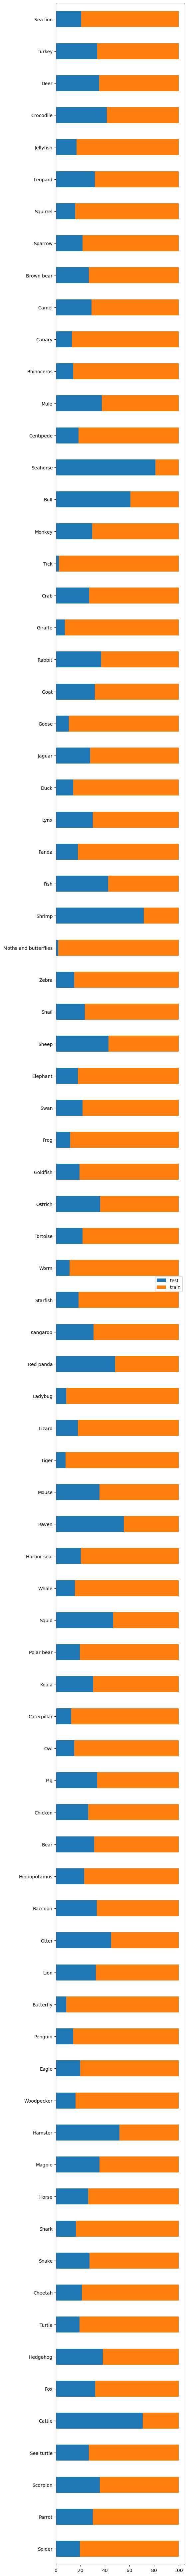

In [14]:
import os

class_names = os.listdir(train_data_dir)

animal_values = []
test_values = []
train_values = []

for name in class_names:
    test_subdirectory_path = os.path.join(test_data_dir, name)
    train_subdirectory_path = os.path.join(train_data_dir, name)
    test_image_count, train_image_count = len(os.listdir(test_subdirectory_path)), len(
        os.listdir(train_subdirectory_path)
    )
    total_image_count = train_image_count + test_image_count
    test_percent = round((test_image_count / total_image_count) * 100, 2)
    train_percent = round((train_image_count / total_image_count) * 100, 2)

    animal_values.append(name)
    test_values.append(test_percent)
    train_values.append(train_percent)
    
df = pd.DataFrame({"test": test_values, "train": train_values}, index=animal_values)

df.plot(
    kind="barh",
    stacked=True,
    figsize=(
        5,
        100,
    ),
)

In [15]:
import tensorflow as tf

batch_size = 32
img_height = 180
img_width = 180

train_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, zoom_range=0.1, rotation_range=0.1, horizontal_flip=True
)
test_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_datagen = train_image_data_generator.flow_from_directory(
    train_data_dir, batch_size=batch_size, class_mode="binary", target_size=(img_width, img_height)
)

test_datagen = test_image_data_generator.flow_from_directory(
    test_data_dir, batch_size=batch_size, class_mode="binary", target_size=(img_width, img_height)
)

Found 22566 images belonging to 80 classes.
Found 6505 images belonging to 80 classes.


In [16]:
animals_number = len(class_names)

# Create the model
model = tf.keras.Sequential(
     [
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same", input_shape=(img_width, img_height, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(animals_number, name="outputs", activation="softmax"),
    ]
)

adam = tf.keras.optimizers.Adam()

model.compile(
    optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"]
)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

## Fitting The Model

In [ ]:
epochs = 4

history = model.fit(
    train_datagen,
    steps_per_epoch=(train_datagen.samples // batch_size),
    epochs=epochs,
    validation_data=test_datagen,
    validation_steps=(test_datagen.samples // batch_size),
)

Visualize the training results

In [20]:
epochs_range = range(epochs)

training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a pd Dataframe for accuracy
acc_df = pd.DataFrame({"Training Accuracy":training_acc, "Validation Accuracy":validation_acc}, index=epochs_range)
# Create a pd Dataframe for loss
loss_df = pd.DataFrame({"Training Loss":training_loss, "Validation Loss":validation_loss}, index=epochs_range)

<AxesSubplot:>

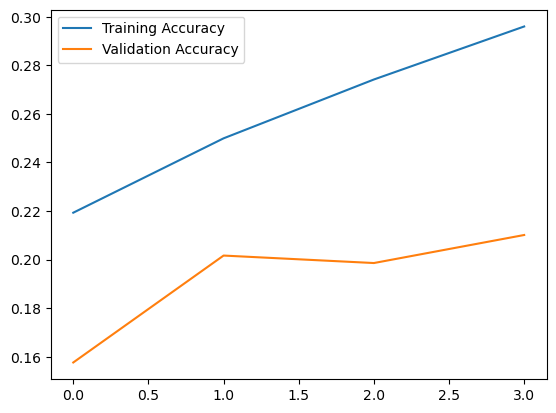

In [21]:
# Plot Accuracy
acc_df.plot()

<AxesSubplot:>

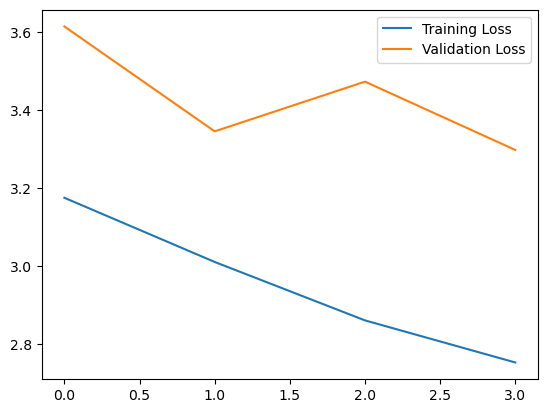

In [22]:
# Plot Loss
loss_df.plot()

saving the model

In [23]:
model.save("animal_detection_model")
# Save only the weights of the model
model.save_weights("animal_detection_model_weights.h5")